In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
def surface_area(v, f):
    def triangle_area(face):
        i, j, k = face
        return 0.5 * jnp.linalg.norm(jnp.cross(v[j]-v[i], v[k]-v[i]))
    return jnp.sum(jax.vmap(triangle_area)(f))

In [3]:
def minimize(loss, x, c, step_size=1e-2, num_steps=100):
    @jax.jit
    def update(x):
        g = jax.grad(loss)(x)
        constrained_g = g.at[c].set(0.)
        return x - step_size * constrained_g
    for i in range(num_steps):
        x = update(x)
    return x

In [4]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

a = jnp.linspace(0, 2*jnp.pi)
b = jnp.linspace(0, 1)
a, b = jnp.meshgrid(a, b)
a, b = a.flatten(), b.flatten()

# triangulate parameter space to determine the triangles
tri = mtri.Triangulation(a, b)
tri.triangles

array([[1827, 1826, 1777],
       [1777, 1826, 1776],
       [1212, 1162, 1163],
       ...,
       [1210, 1260, 1259],
       [1209, 1159, 1210],
       [1159, 1160, 1210]], dtype=int32)

In [5]:
c1 = jnp.where((a == a.min()) | (a == a.max()))[0]
c2 = jnp.where((b == b.min()) | (b == b.max()))[0]
c = jnp.concatenate((c1, c2))
c

DeviceArray([   0,   49,   50,   99,  100,  149,  150,  199,  200,  249,
              250,  299,  300,  349,  350,  399,  400,  449,  450,  499,
              500,  549,  550,  599,  600,  649,  650,  699,  700,  749,
              750,  799,  800,  849,  850,  899,  900,  949,  950,  999,
             1000, 1049, 1050, 1099, 1100, 1149, 1150, 1199, 1200, 1249,
             1250, 1299, 1300, 1349, 1350, 1399, 1400, 1449, 1450, 1499,
             1500, 1549, 1550, 1599, 1600, 1649, 1650, 1699, 1700, 1749,
             1750, 1799, 1800, 1849, 1850, 1899, 1900, 1949, 1950, 1999,
             2000, 2049, 2050, 2099, 2100, 2149, 2150, 2199, 2200, 2249,
             2250, 2299, 2300, 2349, 2350, 2399, 2400, 2449, 2450, 2499,
                0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
               10,   11,   12,   13,   14,   15,   16,   17,   18,   19,
               20,   21,   22,   23,   24,   25,   26,   27,   28,   29,
               30,   31,   32,   33,   34,   35,   

In [6]:
s = 10 + jnp.sin(10*a)
x = s * jnp.cos(a)
y = s * jnp.sin(a)
z = b
# x = jnp.cos(a)
# y = jnp.sin(a)
# z = b

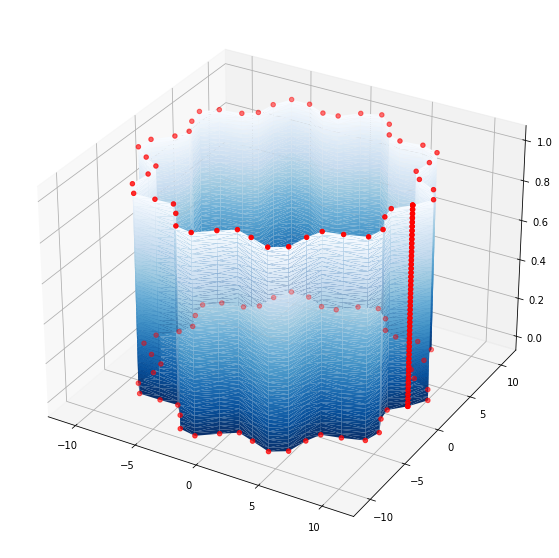

In [7]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_trisurf(x, y, z, triangles=tri.triangles, cmap=plt.cm.Blues_r)
ax.scatter3D(x[c], y[c], z[c], c="red")

In [8]:
v = jnp.vstack((x, y, z)).T
f = tri.triangles
v.shape, f.shape

((2500, 3), (4802, 3))

In [9]:
v2 = minimize(lambda v: surface_area(v, f), v, c, step_size=1e-1, num_steps=10000)

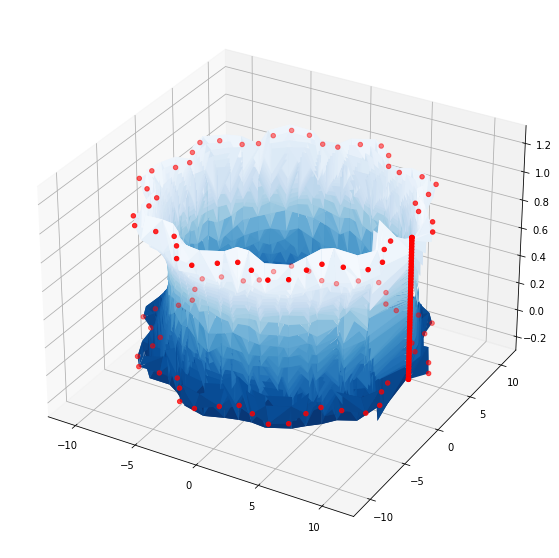

In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_trisurf(v2[:,0], v2[:,1], v2[:,2], triangles=tri.triangles, cmap=plt.cm.Blues_r)
ax.scatter3D(x[c], y[c], z[c], c="red")

TODO it would be nicer to only constrain top/bottom boundaries.

In [11]:
tri.triangles

array([[1827, 1826, 1777],
       [1777, 1826, 1776],
       [1212, 1162, 1163],
       ...,
       [1210, 1260, 1259],
       [1209, 1159, 1210],
       [1159, 1160, 1210]], dtype=int32)

In [12]:
c1

DeviceArray([   0,   49,   50,   99,  100,  149,  150,  199,  200,  249,
              250,  299,  300,  349,  350,  399,  400,  449,  450,  499,
              500,  549,  550,  599,  600,  649,  650,  699,  700,  749,
              750,  799,  800,  849,  850,  899,  900,  949,  950,  999,
             1000, 1049, 1050, 1099, 1100, 1149, 1150, 1199, 1200, 1249,
             1250, 1299, 1300, 1349, 1350, 1399, 1400, 1449, 1450, 1499,
             1500, 1549, 1550, 1599, 1600, 1649, 1650, 1699, 1700, 1749,
             1750, 1799, 1800, 1849, 1850, 1899, 1900, 1949, 1950, 1999,
             2000, 2049, 2050, 2099, 2100, 2149, 2150, 2199, 2200, 2249,
             2250, 2299, 2300, 2349, 2350, 2399, 2400, 2449, 2450, 2499],            dtype=int32)

In [13]:
c1[0::2], c1[1::2]

(DeviceArray([   0,   50,  100,  150,  200,  250,  300,  350,  400,  450,
               500,  550,  600,  650,  700,  750,  800,  850,  900,  950,
              1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450,
              1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950,
              2000, 2050, 2100, 2150, 2200, 2250, 2300, 2350, 2400, 2450],            dtype=int32),
 DeviceArray([  49,   99,  149,  199,  249,  299,  349,  399,  449,  499,
               549,  599,  649,  699,  749,  799,  849,  899,  949,  999,
              1049, 1099, 1149, 1199, 1249, 1299, 1349, 1399, 1449, 1499,
              1549, 1599, 1649, 1699, 1749, 1799, 1849, 1899, 1949, 1999,
              2049, 2099, 2149, 2199, 2249, 2299, 2349, 2399, 2449, 2499],            dtype=int32))

In [27]:
def make_cylinder_triangulation(ni=3, nj=3, periodic_j=True):
    faces = []
    for i in jnp.arange(ni-1):
        for j in jnp.arange(nj-1):
            faces.append([i*ni+j, i*ni+j+1,   (i+1)*ni+j+1])
            faces.append([i*ni+j, (i+1)*ni+j, (i+1)*ni+j+1])
    if periodic_j:
        for i in jnp.arange(ni-1):
            faces.append([i*ni+nj-1,          i*ni, (i+1)*ni])
            faces.append([i*ni+nj-1, (i+1)*ni+nj-1, (i+1)*ni])
    return jnp.array(faces)

print(make_cylinder_triangulation())
jnp.arange(9).reshape(3,3)

[[0 1 4]
 [0 3 4]
 [1 2 5]
 [1 4 5]
 [3 4 7]
 [3 6 7]
 [4 5 8]
 [4 7 8]
 [2 0 3]
 [2 5 3]
 [5 3 6]
 [5 8 6]]


DeviceArray([[0, 1, 2],
             [3, 4, 5],
             [6, 7, 8]], dtype=int32)

[[0 1 4]
 [3 4 7]
 [1 2 5]
 [4 5 8]
 [0 3 4]
 [3 6 7]
 [1 4 5]
 [4 7 8]
 [2 0 3]
 [5 3 6]
 [2 5 3]
 [5 8 6]]


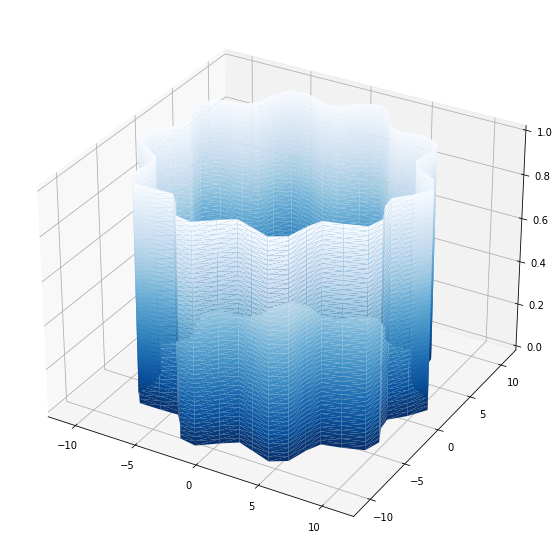

In [51]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_trisurf(x, y, z, triangles=make_cylinder_triangulation2(50, 50), cmap=plt.cm.Blues_r)
# ax.scatter3D(x[c], y[c], z[c], c="red")